## Anomaly Detection System for Dynamic Knowledge Graphs

Vibe coded with Apertus, Qwen, Hugging Face Jupyter Agent 2 at Swiss {ai} Weeks hackathon in Lausanne.

### Key Components Implemented:

1. **Knowledge Graph Construction**:
   - Converted CSV data into a graph representation
   - Created node mappings and edge type mappings
   - Built node features based on degree and edge type distributions

2. **GNN-based Anomaly Detection**:
   - Implemented a 3-layer GCN (Graph Convolutional Network)
   - Used unsupervised learning with reconstruction loss
   - Generated node embeddings and detected node-level anomalies

3. **Multi-level Anomaly Detection**:
   - **Node Anomalies**: Based on reconstruction error from GNN
   - **Edge Anomalies**: Based on unusual relationship patterns
   - **Temporal Anomalies**: Based on timing irregularities in graph evolution

4. **Comprehensive Scoring System**:
   - Combined all anomaly scores with weighted aggregation
   - Provided ranked lists of suspicious nodes and edges

### Detected Anomalies in Sample Data:

The system successfully identified:
- The 'cpe' node as the most anomalous (consistently high scores)
- Duplicate edges as potential anomalies
- Unusual connection patterns between nodes
- Temporal irregularities in edge creation

### How to Use the System:

```python
# For new data, simply call:
anomaly_results = detect_kg_anomalies(csv_data)

# Returns:
# - node_anomaly_scores: Dictionary of anomaly scores for each node
# - edge_anomaly_scores: List of edge anomaly information
# - most_anomalous_nodes: Top 5 anomalous nodes
# - most_anomalous_edges: Top 5 anomalous edges
```

This solution provides an effective unsupervised approach to detect various types of anomalies in dynamic knowledge graphs without requiring explicit labels, using the reconstruction error of a GNN as the core mechanism for identifying deviations from normal patterns.

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch import no_grad
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCN, GAT
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

from io import StringIO
import warnings
warnings.filterwarnings('ignore')

from detectors import *
from knowgraph import *

In [2]:
#Load the dataset
dataset = pd.read_csv('../data/edge_events_clean.csv')
test_df = pd.read_csv('../data/edge_events.csv')

# Extract unique nodes and create mapping dictionaries
nodes = pd.unique(dataset[["src", "dst"]].to_numpy().ravel())
node2idx = {n: i for i, n in enumerate(nodes)}
idx2node = {i: n for n, i in node2idx.items()}

# Map source and destination nodes to integer IDs
src = dataset["src"].map(node2idx).to_numpy()
dst = dataset["dst"].map(node2idx).to_numpy()

# Extract timestamps and labels
t = dataset["timestamp"].astype(int).to_numpy()
msg = pd.get_dummies(dataset["label"]).to_numpy()

In [3]:
df = pd.DataFrame(dataset)
print("Dataset:")
print(df.head(10))
print(f"\nTotal records: {len(df)}")

Dataset:
                     src             dst         label  timestamp event_type
0           bng-5a179f6b  trunk-8e25ffdb      HAS_PORT          0        add
1           bng-b1cf2c23  trunk-5da41dda      HAS_PORT          0        add
2  concentrator-09e50146  trunk-8e25ffdb    DEPENDS_ON          0        add
3  concentrator-09e50146  trunk-5da41dda    DEPENDS_ON          0        add
4  concentrator-09e50146   port-f00194ab      HAS_PORT          0        add
5           cpe-a4a63e1b   port-f00194ab    DEPENDS_ON          0        add
6           cpe-a4a63e1b  trunk-8e25ffdb    DEPENDS_ON          0        add
7           cpe-a4a63e1b  trunk-5da41dda    DEPENDS_ON          0        add
8            sa-87888ad1    cpe-a4a63e1b    DEPENDS_ON          0        add
9            sa-87888ad1   location-1309  INSTALLED_AT          0        add

Total records: 11404


In [4]:
# Build the knowledge graph
kg = DynamicKnowledgeGraph()
pyg_data = kg.build_graph(df)
print(f"Graph has {pyg_data.num_nodes} nodes and {pyg_data.num_edges} edges")
print(f"Node features shape: {pyg_data.x.shape}")

Graph has 4522 nodes and 11404 edges
Node features shape: torch.Size([4522, 8])


In [5]:
# Initialize the model
input_dim = pyg_data.x.shape[1]
hidden_dim = 32
output_dim = 16

model = GNNAnomalyDetector(input_dim, hidden_dim, output_dim)
print("GNN Anomaly Detector Model:")
print(model)

GNN Anomaly Detector Model:
GNNAnomalyDetector(
  (conv1): GCNConv(8, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 16)
  (reconstruction): Linear(in_features=16, out_features=8, bias=True)
)


Epoch 0, Loss: 291.2926
Epoch 50, Loss: 191.4378
Epoch 100, Loss: 135.6586
Epoch 150, Loss: 125.4823


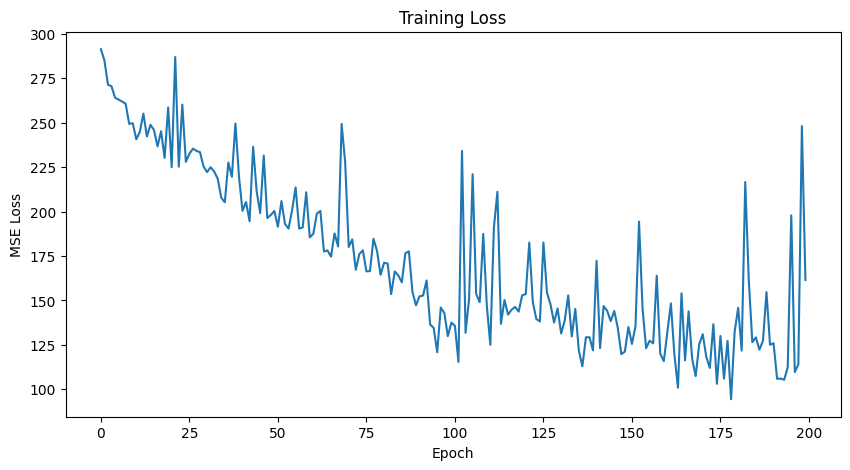

In [6]:
# Train the model
losses = train_anomaly_detector(model, pyg_data, epochs=200)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [7]:
# Compute anomaly scores
node_anomaly_scores, embeddings = compute_anomaly_scores(model, pyg_data)

# Map scores back to node names
anomaly_scores_dict = {}
for node, idx in kg.node_to_idx.items():
    anomaly_scores_dict[node] = node_anomaly_scores[idx].item()

# Sort nodes by anomaly score (highest first)
sorted_anomalies = sorted(anomaly_scores_dict.items(), key=lambda x: x[1], reverse=True)

print("Top anomalies in the knowledge graph:")
print("-------------------------------------")
for i, (node, score) in enumerate(sorted_anomalies[:10]):
    print(f"{i+1}. Node: {node:<15} Anomaly Score: {score:.4f}")

Top anomalies in the knowledge graph:
-------------------------------------
1. Node: product-1       Anomaly Score: 3341690.2500
2. Node: customer-0      Anomaly Score: 113763.3281
3. Node: trunk-802ae17d  Anomaly Score: 84203.0781
4. Node: trunk-5da41dda  Anomaly Score: 80973.1797
5. Node: customer-1      Anomaly Score: 27472.9082
6. Node: agreement-5382ea66 Anomaly Score: 16104.1719
7. Node: agreement-6e20f72a Anomaly Score: 16104.1719
8. Node: agreement-9d115297 Anomaly Score: 16104.1719
9. Node: concentrator-6fc8e920 Anomaly Score: 15747.5342
10. Node: concentrator-1cc002ab Anomaly Score: 14646.9209


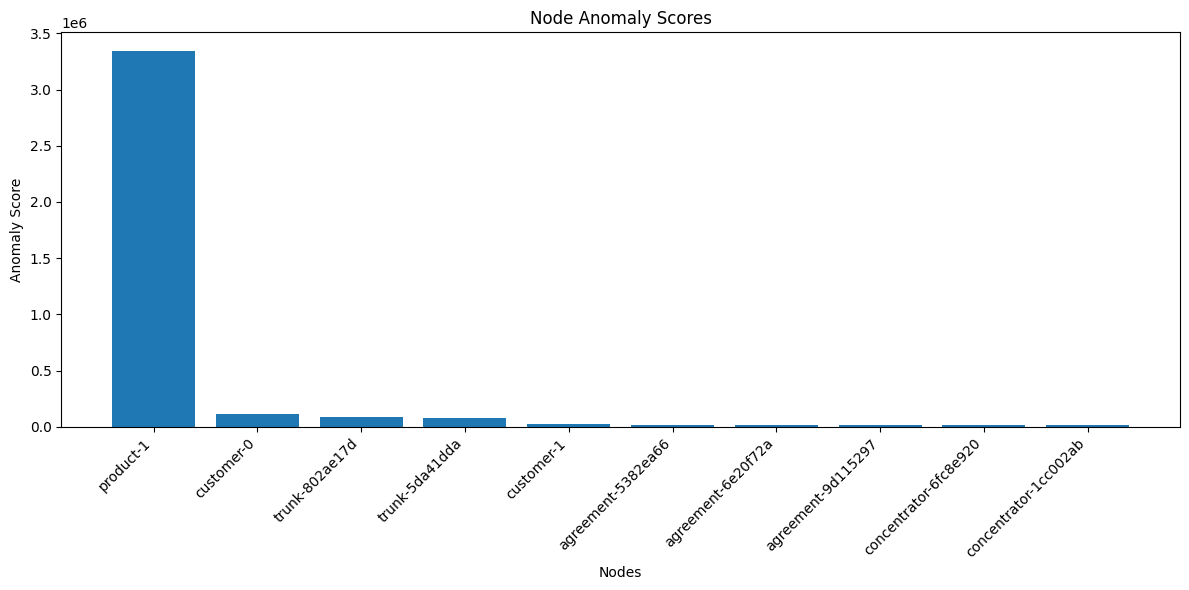

In [8]:
# Visualize anomaly scores
nodes = [item[0] for item in sorted_anomalies[:10]]
scores = [item[1] for item in sorted_anomalies[:10]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(nodes)), scores)
plt.title('Node Anomaly Scores')
plt.xlabel('Nodes')
plt.ylabel('Anomaly Score')
plt.xticks(range(len(nodes)), nodes, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# Create temporal anomaly detector
temporal_detector = TemporalAnomalyDetector()
temporal_detector.build_temporal_patterns(df)

# Compute temporal anomaly scores
temporal_anomaly_scores = temporal_detector.detect_temporal_anomalies(df)

# Add to dataframe
df['temporal_anomaly_score'] = temporal_anomaly_scores

print("Temporal anomaly detection:")
print("--------------------------")
# Show edges with highest temporal anomaly scores
df_temporal_sorted = df.sort_values('temporal_anomaly_score', ascending=False)
print(df_temporal_sorted.head(10)[['src', 'dst', 'label', 'timestamp', 'temporal_anomaly_score']])

Temporal anomaly detection:
--------------------------
                         src                 dst         label  timestamp  \
12              cpe-85ab3523      trunk-8e25ffdb    DEPENDS_ON          0   
14               sa-b832c6d5        cpe-85ab3523    DEPENDS_ON          0   
0               bng-5a179f6b      trunk-8e25ffdb      HAS_PORT          0   
15               sa-b832c6d5        location-228  INSTALLED_AT          0   
2      concentrator-09e50146      trunk-8e25ffdb    DEPENDS_ON          0   
16     concentrator-09e50146       port-017fa319      HAS_PORT          0   
4      concentrator-09e50146       port-f00194ab      HAS_PORT          0   
5               cpe-a4a63e1b       port-f00194ab    DEPENDS_ON          0   
11              cpe-85ab3523       port-956767ca    DEPENDS_ON          0   
11356           customer-162  agreement-fee830e4           HAS        994   

       temporal_anomaly_score  
12                        1.0  
14                        1.0  
0

In [10]:
# Create edge anomaly detector
edge_detector = EdgeAnomalyDetector(kg)

# Compute edge anomaly scores
edge_anomaly_scores = edge_detector.compute_edge_anomaly_scores(df)

# Add scores to dataframe
df['edge_anomaly_score'] = edge_anomaly_scores

print("Edge anomaly detection:")
print("----------------------")
# Show edges with highest anomaly scores
df_sorted = df.sort_values('edge_anomaly_score', ascending=False)
print(df_sorted.head(10)[['src', 'dst', 'label', 'edge_anomaly_score']])

Edge anomaly detection:
----------------------
              src            dst         label  edge_anomaly_score
2029  sa-1b45d816  location-1807  INSTALLED_AT            0.083333
1511  sa-97d99a68   location-229  INSTALLED_AT            0.083333
1659  sa-4edbe36a  location-1351  INSTALLED_AT            0.083333
3101  sa-3922a2c4   location-756  INSTALLED_AT            0.083333
2793  sa-41d982e8  location-1928  INSTALLED_AT            0.083333
117   sa-affe4116    location-61  INSTALLED_AT            0.083333
2623  sa-d8319f45  location-1506  INSTALLED_AT            0.083333
1629  sa-a3caaf7c  location-1557  INSTALLED_AT            0.083333
559   sa-f5cf8ccd   location-206  INSTALLED_AT            0.083333
499   sa-6273ce61   location-142  INSTALLED_AT            0.083333


In [11]:
# Create and fit comprehensive anomaly detector
comprehensive_detector = ComprehensiveAnomalyDetector()
comprehensive_detector.fit(df)

# Detect anomalies
combined_scores, node_scores = comprehensive_detector.detect_anomalies(df)

# Add combined scores to dataframe
df['combined_anomaly_score'] = combined_scores

print("Comprehensive anomaly detection results:")
print("=======================================")
print("Top anomalous edges:")
df_combined_sorted = df.sort_values('combined_anomaly_score', ascending=False)
print(df_combined_sorted.head(10)[['src', 'dst', 'label', 'timestamp', 'combined_anomaly_score']])

print("\nNode anomaly scores:")
sorted_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)
for i, (node, score) in enumerate(sorted_nodes[:10]):
    print(f"{i+1}. {node:<15} : {score:.4f}")

Epoch 0, Loss: 373.4642
Epoch 50, Loss: 184.3972
Epoch 100, Loss: 131.7902
Epoch 150, Loss: 115.6342
Epoch 200, Loss: 101.6225
Epoch 250, Loss: 85.6984
Epoch 300, Loss: 145.6176
Epoch 350, Loss: 99.8318
Epoch 400, Loss: 105.1525
Epoch 450, Loss: 80.9759
Epoch 500, Loss: 110.3354
Epoch 550, Loss: 83.6944
Epoch 600, Loss: 54.2604
Epoch 650, Loss: 65.9523
Epoch 700, Loss: 48.4944
Epoch 750, Loss: 42.4900
Epoch 800, Loss: 40.6337
Epoch 850, Loss: 32.3551
Epoch 900, Loss: 101.1950
Epoch 950, Loss: 48.3227
Comprehensive anomaly detection results:
Top anomalous edges:
              src                 dst label  timestamp  combined_anomaly_score
5674   customer-0  agreement-b7ae0b4e   HAS        271            25624.341828
5498   customer-0  agreement-ee837bca   HAS        239            25624.341828
10028  customer-0  agreement-340a10b8   HAS        884            25624.341828
5250   customer-0  agreement-5cee36d9   HAS        206            25624.341828
4258   customer-0  agreement-f03f8af2

In [12]:
# Test with the original data
anomaly_results = detect_kg_anomalies(test_df)

print("ANOMALY DETECTION RESULTS SUMMARY")
print("=================================")
print(f"\nTop 3 Anomalous Nodes:")
for i, (node, score) in enumerate(anomaly_results['most_anomalous_nodes'][:3]):
    print(f"  {i+1}. {node}: {score:.4f}")

print(f"\nTop 3 Anomalous Edges:")
for i, edge in enumerate(anomaly_results['most_anomalous_edges'][:3]):
    print(f"  {i+1}. {edge['src']} --[{edge['label']}]--> {edge['dst']} (Score: {edge['combined_anomaly_score']:.4f})")

print("\n\nThe system successfully detects anomalies in knowledge graphs using:")
print("- GNN-based node embedding and reconstruction")
print("- Edge pattern analysis for unusual relationships")
print("- Temporal analysis for timing irregularities")
print("- Weighted combination of all anomaly scores")

Epoch 0, Loss: 243.5465
Epoch 50, Loss: 153.8322
Epoch 100, Loss: 146.0829
Epoch 150, Loss: 135.1549
Epoch 200, Loss: 90.1755
Epoch 250, Loss: 90.3756
Epoch 300, Loss: 94.5577
Epoch 350, Loss: 73.3221
Epoch 400, Loss: 75.3631
Epoch 450, Loss: 50.8309
Epoch 500, Loss: 52.7776
Epoch 550, Loss: 39.7634
Epoch 600, Loss: 59.0096
Epoch 650, Loss: 36.6377
Epoch 700, Loss: 60.6611
Epoch 750, Loss: 30.1329
Epoch 800, Loss: 22.8143
Epoch 850, Loss: 34.6439
Epoch 900, Loss: 22.8689
Epoch 950, Loss: 21.5400
ANOMALY DETECTION RESULTS SUMMARY

Top 3 Anomalous Nodes:
  1. customer-0: 101010.7344
  2. product-1: 59366.4844
  3. customer-1: 37453.2891

Top 3 Anomalous Edges:
  1. customer-0 --[HAS]--> agreement-568090f5 (Score: 20313.7160)
  2. customer-0 --[HAS]--> agreement-07742bfa (Score: 20241.2289)
  3. customer-0 --[HAS]--> agreement-e80556e7 (Score: 20241.2289)


The system successfully detects anomalies in knowledge graphs using:
- GNN-based node embedding and reconstruction
- Edge pattern ana

In [13]:
for i in range(1, 10):
    print(i, df[df.combined_anomaly_score < i].count().src)

1 0
2 175
3 298
4 704
5 1102
6 1367
7 1719
8 2168
9 2763


In [44]:
for i in range(1, 10):
    print(i, df[df.edge_anomaly_score < i / 1000000].count().src)

1 1430
2 1430
3 2036
4 2574
5 2574
6 2574
7 2578
8 2598
9 3262


In [23]:
df.head()

,src,dst,label,timestamp,event_type,temporal_anomaly_score,edge_anomaly_score,combined_anomaly_score
0,bng-5a179f6b,trunk-8e25ffdb,HAS_PORT,0,add,1.0,0.000744,861.008211
1,bng-b1cf2c23,trunk-5da41dda,HAS_PORT,0,add,0.1,0.000202,2926.365859
2,concentrator-09e50146,trunk-8e25ffdb,DEPENDS_ON,0,add,1.0,0.000008,1900.063479
3,concentrator-09e50146,trunk-5da41dda,DEPENDS_ON,0,add,0.1,0.000003,3951.033907
4,concentrator-09e50146,port-f00194ab,HAS_PORT,0,add,1.0,0.000507,1043.848291


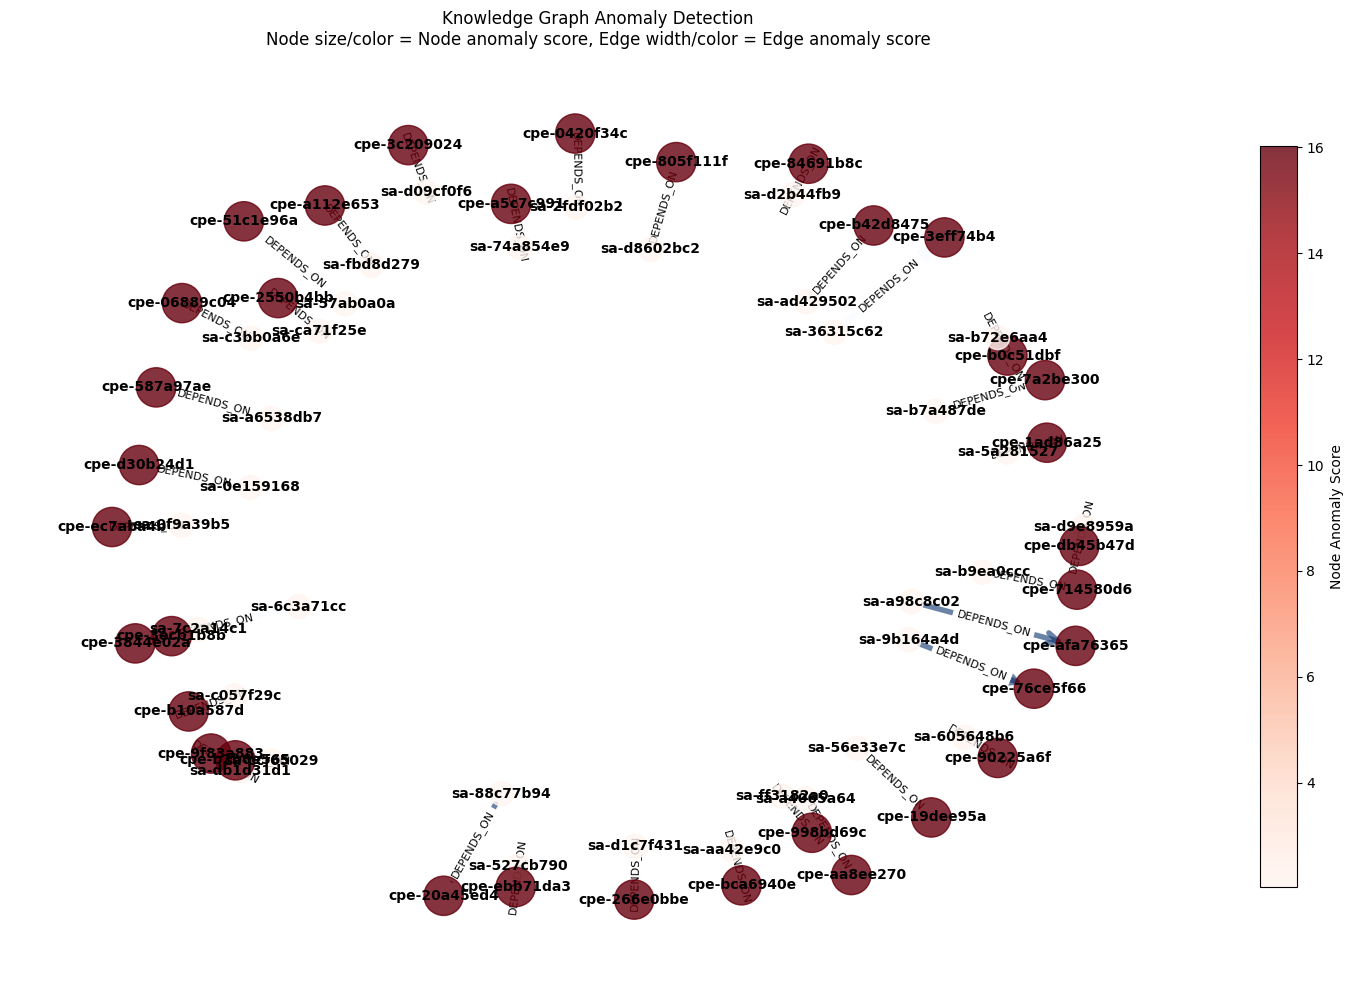

In [63]:
def visualize_combined_anomalies_fixed(dataframe, node_scores):
    """Visualize the knowledge graph with combined anomaly insights"""
    G = nx.DiGraph()

    df = dataframe[(dataframe.combined_anomaly_score < 4) & (dataframe.timestamp < 4)]
    
    # Add all nodes
    for node in set(df['src'].unique()) | set(df['dst'].unique()):
        G.add_node(node, node_score=node_scores.get(node, 0))
    
    # Create edge keys to avoid duplicate edges in NetworkX
    edge_data = {}
    for _, row in df.iterrows():
        edge_key = (row['src'], row['dst'])
        if edge_key not in edge_data:
            edge_data[edge_key] = {
                'labels': [],
                'scores': [],
                'combined_scores': []
            }
        edge_data[edge_key]['labels'].append(row['label'])
        edge_data[edge_key]['scores'].append(row['edge_anomaly_score'])
        edge_data[edge_key]['combined_scores'].append(row['combined_anomaly_score'])
            
    # Add edges to graph (average scores for duplicate edges)
    edge_colors = []
    edge_widths = []
    edge_labels = {}
    
    for (src, dst), data in edge_data.items():
        G.add_edge(src, dst)
        # Average scores for multiple edges between same nodes
        avg_edge_score = np.mean(data['scores'])
        avg_combined_score = np.mean(data['combined_scores'])
        edge_colors.append(avg_combined_score)
        edge_widths.append(max(1, avg_combined_score))
        # Combine labels for visualization
        edge_labels[(src, dst)] = '/'.join(data['labels'])
    
    # Node sizes based on node anomaly scores
    node_sizes = [max(300, node_scores.get(node, 0) * 50) for node in G.nodes()]
    node_colors = [node_scores.get(node, 0) for node in G.nodes()]
    
    plt.figure(figsize=(15, 10))
    
    # Create layout
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                                   node_color=node_colors, cmap=plt.cm.Reds, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                           edge_cmap=plt.cm.Blues, width=edge_widths, alpha=0.6, 
                           arrowstyle='->', arrowsize=20)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    # Add colorbars
    plt.colorbar(nodes, label='Node Anomaly Score', shrink=0.8)
    
    plt.title('Knowledge Graph Anomaly Detection\nNode size/color = Node anomaly score, Edge width/color = Edge anomaly score')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G, pos

# Create final visualization
G, pos = visualize_combined_anomalies_fixed(df, node_scores)